In [1]:
import numpy as np

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

In [17]:
# Parameters
Lx = 10
Nx = 1024
a = 1e-4
b = 2e-4
dealias = 3/2
stop_sim_time = 10
timestepper = d3.SBDF2
timestep = 2e-3
dtype = np.float64

# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(0, Lx), dealias=dealias)

# Fields
u = dist.Field(name='u', bases=xbasis)

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)

# Problem
problem = d3.IVP([u], namespace=locals())
problem.add_equation("dt(u) - a*dx(dx(u)) - b*dx(dx(dx(u))) = - u*dx(u)")

{'eqn': Add(Add(Add(dt(<Field 140690004820624>), Mul(-1, Mul(0.0001, Diff(Diff(<Field 140690004820624>))))), Mul(-1, Mul(0.0002, Diff(Diff(Diff(<Field 140690004820624>)))))), Mul(-1, Mul(Mul(-1, <Field 140690004820624>), Diff(<Field 140690004820624>)))),
 'LHS': Add(Add(dt(<Field 140690004820624>), Mul(-1, Mul(0.0001, Diff(Diff(<Field 140690004820624>))))), Mul(-1, Mul(0.0002, Diff(Diff(Diff(<Field 140690004820624>)))))),
 'RHS': Mul(Mul(-1, <Field 140690004820624>), Diff(<Field 140690004820624>)),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('float64'),
 'valid_modes': array([ True, False,  True, ...,  True,  True,  True]),
 'M': <Field 140690004820624>,
 'L': Add(Mul(-1, Mul(0.0001, Diff(Diff(<Field 140690004820624>)))), Mul(-1, Mul(0.0002, Diff(Diff(Diff(<Field 140690004820624>)))))),
 'F': Mul(Mul(-1, <Field 140690004820624>), Diff(<Field 140690004820624>)),
 'domain': <dedalus.core.domain.Domain at 0x7ff4f1c08c10>,
 'matrix_dependence': array([ True]),
 'matrix_coupling

In [18]:
# Initial conditions
x = dist.local_grid(xbasis)
n = 20
u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*(x-0.2*Lx))**2) / (2*n)

In [19]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2024-11-09 07:57:05,561 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


In [20]:
# Main loop
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 100 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

2024-11-09 07:57:09,277 __main__ 0/1 INFO :: Iteration=100, Time=2.000000e-01, dt=2.000000e-03
2024-11-09 07:57:09,313 __main__ 0/1 INFO :: Iteration=200, Time=4.000000e-01, dt=2.000000e-03
2024-11-09 07:57:09,348 __main__ 0/1 INFO :: Iteration=300, Time=6.000000e-01, dt=2.000000e-03
2024-11-09 07:57:09,383 __main__ 0/1 INFO :: Iteration=400, Time=8.000000e-01, dt=2.000000e-03
2024-11-09 07:57:09,418 __main__ 0/1 INFO :: Iteration=500, Time=1.000000e+00, dt=2.000000e-03
2024-11-09 07:57:09,453 __main__ 0/1 INFO :: Iteration=600, Time=1.200000e+00, dt=2.000000e-03
2024-11-09 07:57:09,488 __main__ 0/1 INFO :: Iteration=700, Time=1.400000e+00, dt=2.000000e-03
2024-11-09 07:57:09,523 __main__ 0/1 INFO :: Iteration=800, Time=1.600000e+00, dt=2.000000e-03
2024-11-09 07:57:09,558 __main__ 0/1 INFO :: Iteration=900, Time=1.800000e+00, dt=2.000000e-03
2024-11-09 07:57:09,593 __main__ 0/1 INFO :: Iteration=1000, Time=2.000000e+00, dt=2.000000e-03
2024-11-09 07:57:09,627 __main__ 0/1 INFO :: Iter

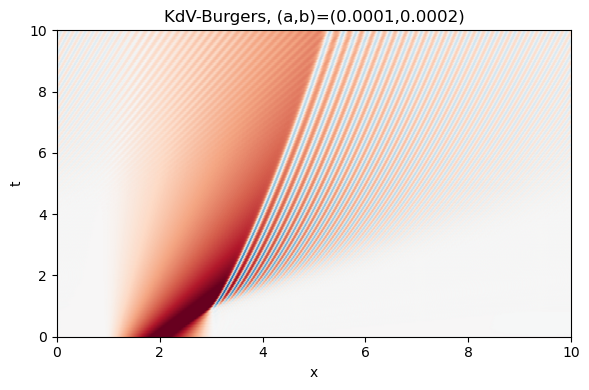

In [21]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_list), np.array(u_list), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-0.8, 0.8))
plt.xlim(0, Lx)
plt.ylim(0, stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'KdV-Burgers, (a,b)=({a},{b})')
plt.tight_layout()
plt.savefig('kdv_burgers.pdf')
plt.savefig('kdv_burgers.png', dpi=200)